In [32]:
import mdtraj as md
import numpy as np
import nglview as nv
from rdkit import Chem
from rdkit.Chem import AllChem

from openmm import app
from openmm import unit
import simtk.openmm as mm
from simtk.openmm.app import Modeller, ForceField, PDBFile

from openmmforcefields.generators import SMIRNOFFTemplateGenerator

import openff.toolkit
from openff.toolkit.typing.engines.smirnoff import ForceField as openffForcefield
from openff.toolkit.topology import Molecule, Topology

## Extracting a Ligand from 1QKU PDB

In [33]:
traj = md.load("../1_system_inspection/1QKU.pdb")
topology = traj.topology
print(traj)
print(topology)

<mdtraj.Trajectory with 1 frames, 6596 atoms, 1343 residues, and unitcells>
<mdtraj.Topology with 9 chains, 1343 residues, 6596 atoms, 6123 bonds>


In [34]:
# Extract all three ligands
ligands = traj.atom_slice(topology.select("not water and not protein"))
print(ligands.topology)
# Extract a single ligand
ligand = ligands.atom_slice(ligands.topology.select("chainid == 0"))
view = nv.show_mdtraj(ligand)
view

<mdtraj.Topology with 3 chains, 3 residues, 60 atoms, 69 bonds>


NGLWidget()

In [35]:
ligand.save_pdb("./ligand.pdb")

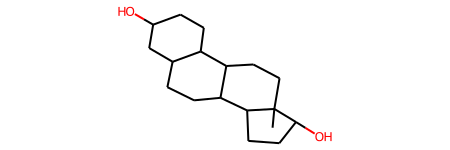

In [36]:
ligand_pdb = Chem.rdmolfiles.MolFromPDBFile("./ligand.pdb")
ligand_pdb

Bond orders are incorrect. PDB files do not store information about bond orders for ligands.

## Fixing ligand bonds

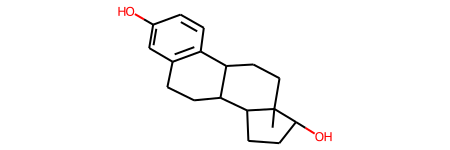

In [37]:
# Assing bond orders from smiles
template_mol = Chem.MolFromSmiles("C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O")
ligand_fixed = AllChem.AssignBondOrdersFromTemplate(template_mol, ligand_pdb)
ligand_fixed

In [38]:
ligand_fixed.GetNumConformers()

1

In [39]:
# Add Hydrogens
ligand_H = Chem.AddHs(ligand_fixed, addCoords=True)
view = nv.show_rdkit(ligand_H)
view

NGLWidget()

In [40]:
# Save ligand to file so openff can use it
writer = Chem.SDWriter("./ligand.sdf")
writer.write(ligand_H)

## Ligand System Parametrized with OpenFF Parsley

First load the ligand

In [41]:
ligand = Molecule.from_file("./ligand.sdf")
lig_topology = ligand.to_topology()
print("Number of conformers: {}".format(len(ligand.conformers)))
lig_positions = ligand.conformers[0]

Number of conformers: 1


### Load the forcefield

In [42]:
forcefield = ForceField("amber99sb.xml", "tip3p.xml")
# Teach OpenMM about the ligand molecule and the Parsley force field
smirnoff = SMIRNOFFTemplateGenerator(forcefield="openff-1.3.0.offxml", molecules=[ligand])
forcefield.registerTemplateGenerator(smirnoff.generator)

### Model and solvate ligand

In [52]:
modeller = Modeller(lig_topology.to_openmm(), lig_positions)

In [53]:
geometric_center = modeller.positions.sum(axis=0)/modeller.positions.shape[0]

In [54]:
modeller.positions = modeller.positions - geometric_center

In [55]:
max_size = max(max((pos[i] for pos in modeller.positions))-min((pos[i] for pos in modeller.positions)) for i in range(3))
vectors = mm.Vec3(1.0, 0, 0), mm.Vec3(1.0/3.0, 2.0*np.sqrt(2.0)/3.0,0.0), mm.Vec3(-1.0/3.0, np.sqrt(2.0)/3.0, np.sqrt(6.0)/3.0)
box_vectors = [(max_size + 14*unit.angstroms)*v for v in vectors]

modeller.addSolvent(forcefield, model='tip3p', boxVectors = box_vectors, neutralize=True)
#modeller.addSolvent(forcefield, model='tip3p', padding=14*unit.angstroms, neutralize=True)

In [47]:
n_waters = 0
for chain in modeller.topology.chains():
    for residue in chain.residues():
        if residue.name=='HOH':
            n_waters += 1

print('n_waters: {}'.format(n_waters))

n_waters: 1718


In [56]:
system = forcefield.createSystem(
    modeller.topology, 
    nonbondedMethod=app.NoCutoff
)

In [57]:
system.getNumParticles()

962

In [58]:
# Visualize ligand with water
topology = modeller.getTopology()
positions = modeller.getPositions()
PDBFile.writeFile(topology, positions, open('ligand_solvated.pdb', 'w'))

In [59]:
view = nv.show_structure_file("ligand_solvated.pdb")
view.add_licorice(selection="(not protein)") # View water molecules
view

NGLWidget()